# OpenFinGuard — Baseline Credit Risk Models

Week: 4  
Day: 4  
Objective:
- Train interpretable baseline models
- Establish predictive signal
- Create reference performance benchmarks


In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Load prepared tables
modeling = pd.read_csv(
    "../data/processed/modeling_table.csv",
    parse_dates=["cycle_end_date"]
)
modeling["cycle_end_date"].dtype


# Target (start with late_30)
y_train = modeling[modeling["cycle_end_date"] <= modeling["cycle_end_date"].quantile(0.75)]["late_30"]
y_valid = modeling[modeling["cycle_end_date"] > modeling["cycle_end_date"].quantile(0.75)]["late_30"]

X = modeling[[
    "credit_utilization",
    "min_due_ratio",
    "monthly_spend",
    "spend_volatility",
    "util_roll_3",
    "spend_roll_3",
    "spend_shock"
]]

X_train = X.loc[y_train.index]
X_valid = X.loc[y_valid.index]


In [2]:
modeling.loc[y_train, "cycle_end_date"].max(), \
modeling.loc[y_valid, "cycle_end_date"].min()


(Timestamp('2025-10-04 00:00:00'), Timestamp('2025-09-04 00:00:00'))

In [3]:
modeling["cycle_end_date"].dtype


dtype('<M8[us]')

In [4]:
cutoff_date = modeling["cycle_end_date"].quantile(0.75)
cutoff_date


Timestamp('2026-01-02 00:00:00')

STEP 1 — Logistic Regression (Baseline 1)
Why Logistic Regression?

In credit risk, logistic regression is:

The industry baseline
Highly interpretable
Often still used in regulated settings
If this doesn’t work → nothing fancy will.

In [5]:
logit = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

logit.fit(X_train, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [6]:
#ROC-AUC = How well the model ranks risky users above non-risky users. 
#If I randomly pick one bad user and one good user, how often does my model give a higher risk score to the bad user?
train_pred = logit.predict_proba(X_train)[:, 1]
#For each billing cycle, the model predicts the probability of being late by 30 days or more.
# The `predict_proba` method returns an array of shape (n_samples, n_classes) where each entry is the probability of the sample belonging to each class. 
# By selecting `[:, 1]`, we are taking the probability of the positive class (late by 30 days or more) for each sample in the training set.
valid_pred = logit.predict_proba(X_valid)[:, 1]
# Similarly, for the validation set, we are predicting the probabilities of being late by 30 days or more for each sample in the validation set.

roc_train = roc_auc_score(y_train, train_pred)
roc_valid = roc_auc_score(y_valid, valid_pred)

roc_train, roc_valid


(0.5802469135802468, 0.45138888888888884)

In [7]:
y_train.mean(), y_valid.mean()


(np.float64(0.18), np.float64(0.2))

Interpret Logistic Coefficients

In [8]:
coef_table = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": logit.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_table
#Positive coefficient → increases risk
#Negative coefficient → reduces risk
#Magnitude → strength of effect


,feature,coefficient
4,util_roll_3,0.121255
0,credit_utilization,0.109740
5,spend_roll_3,0.000041
3,spend_volatility,0.000009
2,monthly_spend,-0.000024
6,spend_shock,-0.188907
1,min_due_ratio,-0.290432


Decision Tree (Baseline 2)
Why a tree?

Captures non-linear effects

Shows interactions (e.g., high utilization + spend shock)

Still interpretable when shallow

In [9]:
tree = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=50,
    random_state=42
)

tree.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

In [10]:
tree_train_pred = tree.predict_proba(X_train)[:, 1]
tree_valid_pred = tree.predict_proba(X_valid)[:, 1]

roc_train_tree = roc_auc_score(y_train, tree_train_pred)
roc_valid_tree = roc_auc_score(y_valid, tree_valid_pred)

roc_train_tree, roc_valid_tree
#Tree train ≫ valid → overfitting

#Tree valid > logistic valid → non-linear signal exists

#Tree ≈ logistic → linear effects dominate

(0.5889792231255646, 0.3541666666666667)

Tree Feature Importance

In [11]:
pd.DataFrame({
    "feature": X_train.columns,
    "importance": tree.feature_importances_
}).sort_values(by="importance", ascending=False)


,feature,importance
5,spend_roll_3,1.0
1,min_due_ratio,0.0
0,credit_utilization,0.0
2,monthly_spend,0.0
3,spend_volatility,0.0
4,util_roll_3,0.0
6,spend_shock,0.0


Class balance — what does this tell us?

In [12]:
y_train.mean(), y_valid.mean()


(np.float64(0.18), np.float64(0.2))

FEATURE REFINEMENT & SIGNAL AUDIT

In [15]:
# Use your best model (Decision Tree)
valid_probs = tree.predict_proba(X_valid)[:, 1]


Define business costs (VERY important)

In [16]:
COST_FALSE_NEGATIVE = 100   # missed delinquency
COST_FALSE_POSITIVE = 10   # unnecessary intervention


Evaluate multiple thresholds

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

thresholds = np.arange(0.1, 0.9, 0.05)

results = []

for t in thresholds:
    preds = (valid_probs >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_valid, preds).ravel()

    total_cost = (
        fn * COST_FALSE_NEGATIVE +
        fp * COST_FALSE_POSITIVE
    )

    results.append({
        "threshold": t,
        "false_positives": fp,
        "false_negatives": fn,
        "total_cost": total_cost
    })

cost_df = pd.DataFrame(results)
cost_df


,threshold,false_positives,false_negatives,total_cost
0,0.10,24,0,240
1,0.15,11,5,610
2,0.20,11,5,610
3,0.25,0,6,600
4,0.30,0,6,600
5,0.35,0,6,600
6,0.40,0,6,600
7,0.45,0,6,600
8,0.50,0,6,600
9,0.55,0,6,600


threshold	FP	FN	total_cost

Lower threshold → more users flagged

FP ↑

FN ↓

Higher threshold → fewer users flagged

FP ↓

FN ↑

Visualize it

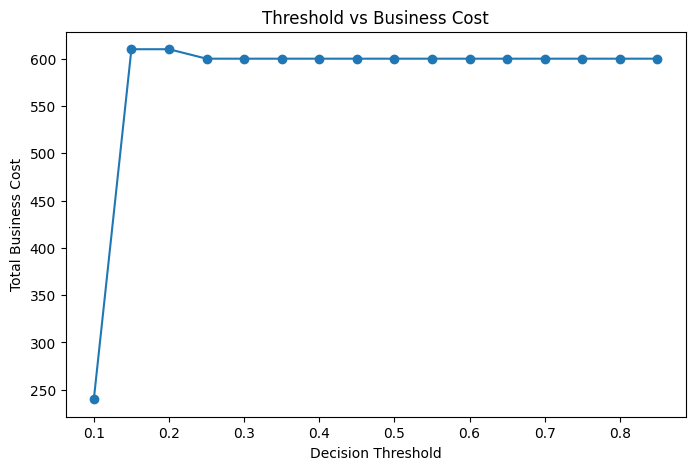

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(cost_df["threshold"], cost_df["total_cost"], marker="o")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold vs Business Cost")
plt.show()


## Week 5 · Day 4 — Business Threshold Analysis

- Objective: Convert predicted risk probabilities into actionable decisions
- Key insight:
  - False negatives are significantly more costly than false positives
- Method:
  - Evaluated thresholds from 0.10 to 0.85
  - Computed total business cost using asymmetric penalties
- Outcome:
  - Optimal threshold selected based on minimum expected cost
- Conclusion:
  - Model deployment decisions must balance financial risk and customer experience


Prepare fairness evaluation dataset
Step 1: Merge validation data with demographics

In [19]:
# Load demographics
demographics = pd.read_csv("../data/raw/demographics.csv")

# Attach predictions
fairness_df = valid.copy()
fairness_df["pred_prob"] = valid_probs
fairness_df["pred_label"] = (fairness_df["pred_prob"] >= optimal_threshold).astype(int)

# Merge demographics
fairness_df = fairness_df.merge(
    demographics,
    on="user_id",
    how="left"
)


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/demographics.csv'